Setting nprobe when you crack like this is hard.
Perhaps we can search all centroids that fall within a specific distance from the query or something? Would that benefit us at all?

In [1]:
import os
import numpy as np
import logging
import faiss
from vasili_helpers import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

%load_ext autoreload
%autoreload 2

In [2]:
faiss.omp_get_max_threads()
# faiss.omp_set_num_threads(1)

128

In [3]:
xb, xq, xt, gt, metric = load_sift1M(f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")

Loading sift1M...

dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)


done


In [4]:
k=100
nlist = 1000
nprobe = 20
d = xb.shape[1]
compute_GT = True
SEED = int(time.time())

### init trained index
# ndex for coarse quantization
trained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
trained_index = faiss.IndexIVFFlat(trained_quantizer, d, nlist, faiss.METRIC_L2)
trained_index.cp.seed = SEED
trained_index.cp.niter= 25
trained_index.cp.nredo = 1
trained_index.verbose=True
# Train the IVF index
trained_index.train(xb)
trained_index.add(xb)

### init untrained index
untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = SEED #int(time.time())
untrained_index.cp.niter= 0
untrained_index.verbose=True
untrained_index.train(xb)
untrained_index.add(xb)


### init untrained index
train1_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
train1_index = faiss.IndexIVFFlat(train1_quantizer, d, nlist, faiss.METRIC_L2)
train1_index.cp.seed = SEED
train1_index.cp.niter= 1
train1_index.verbose=True
train1_index.train(xb)
train1_index.add(xb)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [5]:
_, selected_vectors, gt_selected_vectors, _ = get_skewed_dataset(xb, 
                                skew_on_centroid=0, 
                                nlist=1000, 
                                compute_GT = True, 
                                nearest_cents_to_include=10,
                                seed=SEED,
                                )
xq.shape
selected_vectors.shape

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


(10000, 128)

(10300, 128)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


(10300, 128)

- Total number of unique centroids visited: 384
- % of total centroids: 38.0 %


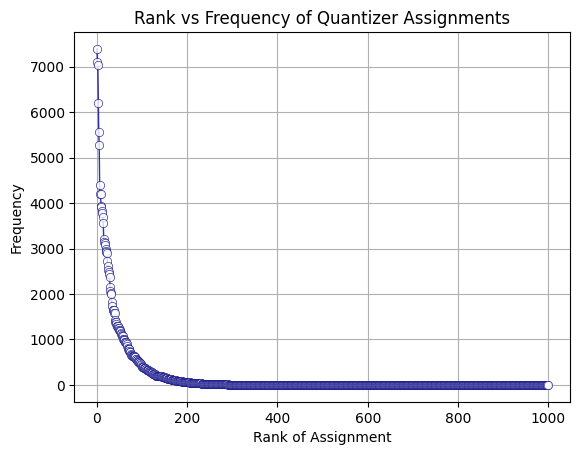

nprobe=20
trained recall: 


0.9542203883495146

trained 1 niter recall: 


0.9412650485436893

untrained recall: 


0.9225

In [6]:
_, selected_vectors, gt_selected_vectors, _ = get_skewed_dataset(xb, 
                                skew_on_centroid=0, 
                                nlist=1000, 
                                compute_GT = True, 
                                nearest_cents_to_include=10,
                                seed=SEED,
                                )
selected_vectors.shape

## plot skew
visited_cids = get_centroid_ids_per_query(
    # index_ivf, 
    untrained_index, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

# recall target
print(f"{nprobe=}")
print("trained recall: ")
trained_index.nprobe = nprobe
_, res_ids = trained_index.search(selected_vectors, k)
compute_recall(res_ids, gt_selected_vectors, k)

# recall target
print("trained 1 niter recall: ")
train1_index.nprobe = nprobe
_, ids_train1 = train1_index.search(selected_vectors, k)
compute_recall(ids_train1, gt_selected_vectors, k)

# recall target
print("untrained recall: ")
untrained_index.nprobe = nprobe
_, res_ids_untrained = untrained_index.search(selected_vectors, k)
compute_recall(res_ids_untrained, gt_selected_vectors, k)

In [4]:
# ### init trained index
# # ndex for coarse quantization
# trained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
# trained_index = faiss.IndexIVFFlat(trained_quantizer, d, nlist, faiss.METRIC_L2)
# trained_index.cp.seed = SEED
# trained_index.cp.niter= 25
# trained_index.cp.nredo = 1
# trained_index.verbose=True
# # Train the IVF index
# trained_index.train(xb)
# trained_index.add(xb)

### init untrained index
# untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
# untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
# untrained_index.cp.seed = SEED
# untrained_index.cp.niter= 0
# untrained_index.verbose=True
# untrained_index.train(xb)
# untrained_index.add(xb)

# ### init untrained index
# train1_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
# train1_index = faiss.IndexIVFFlat(train1_quantizer, d, nlist, faiss.METRIC_L2)
# train1_index.cp.seed = SEED
# train1_index.cp.niter= 1
# train1_index.verbose=True
# train1_index.train(xb)
# train1_index.add(xb)


In [45]:
import numpy as np
import faiss

def create_cracked_index(from_index, visited_cids, selected_vectors, xb, d, nlist, keep_size=900, train_xq=False):
    """
    Creates a cracked index by combining visited centroids, random unvisited centroids, 
    and additional vectors to reach the desired size.

    Args:
        train_index: The trained index to extract centroids.
        untrained_index: The untrained index for reconstruction.
        visited_cids: The indices of centroids already visited.
        selected_vectors: Additional vectors for centroids.
        xb: Data points to add to the index.
        d: Dimensionality of the vectors.
        nlist: Total number of desired centroids.
        keep_size: Desired size of trimmed centroids (default 900).

    Returns:
        A cracked Faiss IndexIVFFlat with the new centroids.
    """
    # Step 1: Reconstruct centroids from the trained index
    centrs = from_index.quantizer.reconstruct_n()
    # Step 2: Get indices of centroids not in visited_cids
    all_indices = np.arange(nlist)
    remaining_indices = np.setdiff1d(all_indices, visited_cids)

    # Step 3: Calculate number of additional centroids needed
    additional_needed = keep_size - len(visited_cids)

    # Step 4: Randomly sample additional centroids without replacement
    # print(f"{additional_needed=}")
    # print(f"{len(remaining_indices)=}")
    additional_indices = (
        np.random.choice(remaining_indices, size=additional_needed, replace=False)
        if additional_needed > 0
        else np.array([])
    )

    # Step 5: Combine visited_cids and additional_indices
    final_indices = np.concatenate([visited_cids, additional_indices])
    trimmed_cents = centrs[final_indices]

    if train_xq:
        quantizer = faiss.IndexFlatL2(d)
        xq_centr_size=nlist-keep_size
        print(f"{xq_centr_size=}")
        qx_ood_index = faiss.IndexIVFFlat(quantizer, d, xq_centr_size, faiss.METRIC_L2)#METRIC_INNER_PRODUCT)  # Use INNER_PRODUCT for angular
        # trained_index.cp.seed = int(time.time())
        qx_ood_index.cp.niter= 10
        qx_ood_index.cp.nredo = 1
        qx_ood_index.cp.max_points_per_centroid = 256 # dont sample
        qx_ood_index.verbose=True
        qx_ood_index.train(selected_vectors)
        qx_cnetrs= qx_ood_index.quantizer.reconstruct_n()
        combined_centroids = np.vstack((trimmed_cents, qx_cnetrs))
    else:
        # random choice from selected_vectors
        rndm = selected_vectors[np.random.choice(selected_vectors.shape[0], size=nlist - trimmed_cents.shape[0], replace=False), :]
        combined_centroids = np.vstack((trimmed_cents, rndm))

    # Step 7: Create and populate the cracked index
    cracked_quantizer = faiss.IndexFlatL2(d)
    cracked_quantizer.add(combined_centroids)
    cracked_index = faiss.IndexIVFFlat(cracked_quantizer, d, len(combined_centroids), faiss.METRIC_L2)
    cracked_index.verbose = True
    cracked_index.add(xb)  # Add points again with the new centroids from the cracking

    return cracked_index

In [46]:
selected_vectors.shape

(10300, 128)

In [108]:
ratio_of_q = 0.1
keep_size = int( (1-ratio_of_q) * nlist )
# keep_size = nlist-500
print(f"{keep_size=}")
cracked_index = create_cracked_index(untrained_index, visited_cids, selected_vectors, xb, d, nlist, keep_size)
# cracked_index_2 = create_cracked_index(train1_index, visited_cids, selected_vectors, xb, d, nlist, keep_size)
cracked_index_2 = create_cracked_index(trained_index, visited_cids, selected_vectors, xb, d, nlist, keep_size)

# cracked_index_2 = create_cracked_index(untrained_index, visited_cids, selected_vectors, xb, d, nlist, keep_size, train_xq=True)
# cracked_index_2.nlist

keep_size=900
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [101]:
# # centrs = untrained_index.quantizer.reconstruct_n()
# centrs = train1_index.quantizer.reconstruct_n()

# visited_cids.shape # the ones we visited from untrained index ( leave these as is don't remove them )
# # not_visited_ids = # the ones we did not visite
# # trimmed_cents = centrs[visited_cids]

# keep_size = 900  # Desired size of trimmed centroids

# # Step 1: Get indices of centroids not in visited_cids
# all_indices = np.arange(nlist)
# remaining_indices = np.setdiff1d(all_indices, visited_cids)

# # Step 2: Calculate number of additional centroids needed
# additional_needed = keep_size - len(visited_cids)

# # Step 3: Randomly sample additional centroids without replacement
# if additional_needed > 0:
#     additional_indices = np.random.choice(remaining_indices, size=additional_needed, replace=False)
# else:
#     additional_indices = np.array([])  # No additional centroids needed

# # Step 4: Combine visited_cids and additional_indices
# final_indices = np.concatenate([visited_cids, additional_indices])
# trimmed_cents = centrs[final_indices]

# # Result

# trimmed_cents.shape
# # combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), selected_vectors[:100,:])) # 100 random from selected vectors
# rndm = selected_vectors[np.random.choice(selected_vectors.shape[0], size=nlist-trimmed_cents.shape[0], replace=False), :]
# combined_centroids  = np.vstack((trimmed_cents, rndm))

# # first_x = selected_vectors[:nlist-trimmed_cents.shape[0],:]
# # combined_centroids  = np.vstack((trimmed_cents, first_x))

# # combined_centroids  = np.vstack((trimmed_cents, km_xq.centroids))
# print(f"{len(combined_centroids)=}")

# cracked_quantizer_2 = faiss.IndexFlatL2(d)
# cracked_quantizer_2.add(combined_centroids)
# cracked_index_2 = faiss.IndexIVFFlat(cracked_quantizer_2, d, len(combined_centroids), faiss.METRIC_L2)
# cracked_index_2.verbose = True
# cracked_index_2.add(xb) # add points again with the new centroids form the cracking


In [102]:
ivf_stats = faiss.cvar.indexIVF_stats

In [113]:
nprobe = 20
nprobe_cracked  = 25 # CHEF NOTE: this is hard to set depends how you broke it up
k=100

print()
print("untrained")
ivf_stats.reset()
untrained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev = untrained_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = untrained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
untrained_nds = ivf_stats.ndis
print(f"untraied ndis = {ivf_stats.ndis}")
# Compute Recall@k
recall_at_k = compute_recall(indices_prev, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")
print()


print("trained niter=1")
ivf_stats.reset()
train1_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained_1 = train1_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = trained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
once_trained_ndis = ivf_stats.ndis
print(f"trained ndis = {ivf_stats.ndis}")
recall_at_k = compute_recall(indices_prev_trained_1, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")

print()
print("trained")
ivf_stats.reset()
trained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained = trained_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = trained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
trained_ndis = ivf_stats.ndis
print(f"trained ndis = {ivf_stats.ndis}")
# Compute Recall@k
recall_at_k = compute_recall(indices_prev_trained, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


print()
print("cracked from untrained")
ivf_stats.reset()
cracked_index.nprobe = nprobe_cracked  # number of clusters to search
distances, idx = cracked_index.search(selected_vectors, k)  # perform search
cracked_ndis = ivf_stats.ndis
# Compute Recall@k
print(f"{cracked_ndis=}")
recall_at_k = compute_recall(idx, gt_selected_vectors, k)
# recall_at_k = compute_recall(idx2, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


print()
print("cracked from train 1 == cracked_index_2")
ivf_stats.reset()
cracked_index_2.nprobe = nprobe_cracked  # number of clusters to search
distances, idx2 = cracked_index_2.search(selected_vectors, k)  # perform search
cracked_ndis_2 = ivf_stats.ndis
# Compute Recall@k
print(f"{cracked_ndis_2=}")
recall_at_k = compute_recall(idx2, gt_selected_vectors, k)
# recall_at_k = compute_recall(idx2, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


untrained
untraied ndis = 290846589
Recall@100: 0.9225

trained niter=1
trained ndis = 232945583
Recall@100: 0.9413

trained
trained ndis = 220470393
Recall@100: 0.9542

cracked from untrained
cracked_ndis=145161924
Recall@100: 0.8995

cracked from train 1 == cracked_index_2
cracked_ndis_2=177543367
Recall@100: 0.9499


In [114]:
# cracked from trained once
print("vs trained full")
print(cracked_ndis_2)
print(cracked_ndis_2 - trained_ndis) # trained
print((cracked_ndis_2 - trained_ndis)/(trained_ndis) * 100, "%")
print("vs trained once")
print(cracked_ndis_2 - once_trained_ndis) # untrained
print((cracked_ndis_2 - once_trained_ndis)/(once_trained_ndis) * 100, "%")
print("vs untrained")
print(cracked_ndis_2 - untrained_nds) # untrained
print((cracked_ndis_2 - untrained_nds)/(untrained_nds) * 100 ,"%")

vs trained full
177543367
-42927026
-19.47065336795585 %
vs trained once
-55402216
-23.78332968863376 %
vs untrained
-113303222
-38.956352346975606 %


In [104]:
# cracked from untrained
print("vs trained full")
print(cracked_ndis)
print(cracked_ndis - trained_ndis) # trained
print((cracked_ndis - trained_ndis)/(trained_ndis) * 100, "%")
print("vs trained once")
print(cracked_ndis - once_trained_ndis) # untrained
print((cracked_ndis - once_trained_ndis)/(once_trained_ndis) * 100, "%")
print("vs untrained")
print(cracked_ndis - untrained_nds) # untrained
print((cracked_ndis - untrained_nds)/(untrained_nds) * 100 ,"%")

vs trained full
203474336
-16996057
-7.708997461622885 %
vs trained once
-29471247
-12.651558626033275 %
vs untrained
-87372253
-30.040666215274058 %


In [91]:
# cracked from trained once
print("vs trained full")
print(cracked_ndis_2)
print(cracked_ndis_2 - trained_ndis) # trained
print((cracked_ndis_2 - trained_ndis)/(trained_ndis) * 100, "%")
print("vs trained once")
print(cracked_ndis_2 - once_trained_ndis) # untrained
print((cracked_ndis_2 - once_trained_ndis)/(once_trained_ndis) * 100, "%")
print("vs untrained")
print(cracked_ndis_2 - untrained_nds) # untrained
print((cracked_ndis_2 - untrained_nds)/(untrained_nds) * 100 ,"%")

vs trained full
221243479
773086
0.3506529786065197 %
vs trained once
-11702104
-5.023535475235862 %
vs untrained
-69603110
-23.93121069059538 %


- Total number of unique centroids visited: 1751
- % of total centroids: 22.0 %


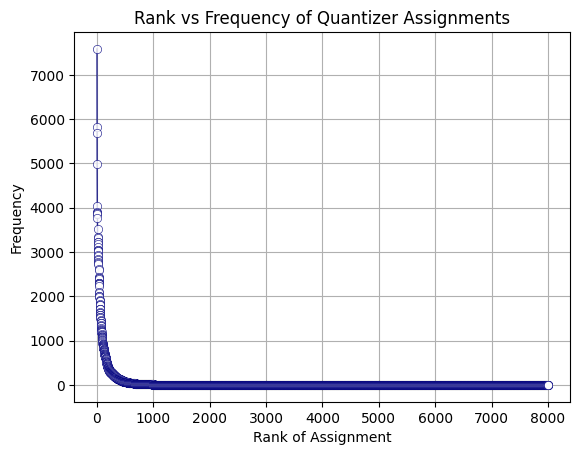

(276246,)

- Total number of unique centroids visited: 1891
- % of total centroids: 24.0 %


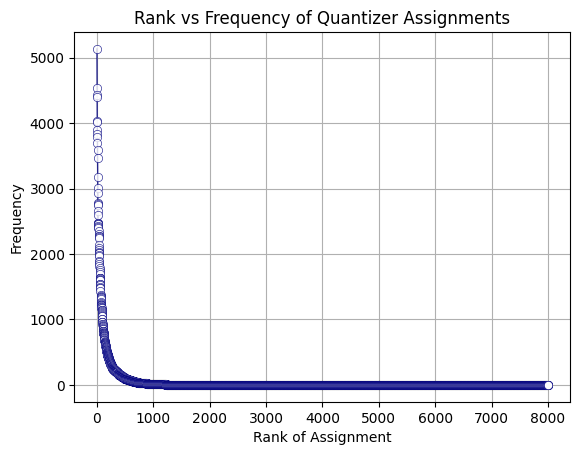

(256358,)

- Total number of unique centroids visited: 2431
- % of total centroids: 30.0 %


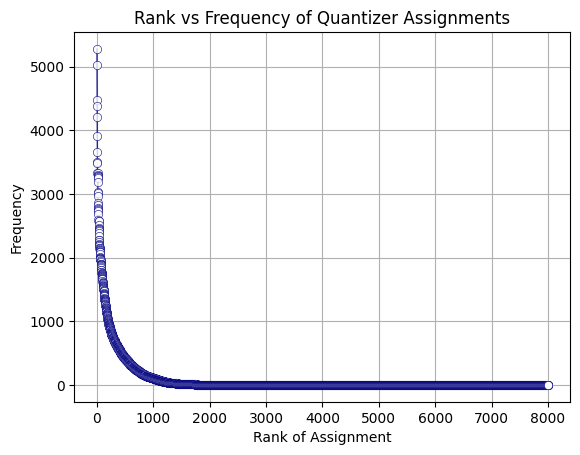

(274931,)

- Total number of unique centroids visited: 2850
- % of total centroids: 36.0 %


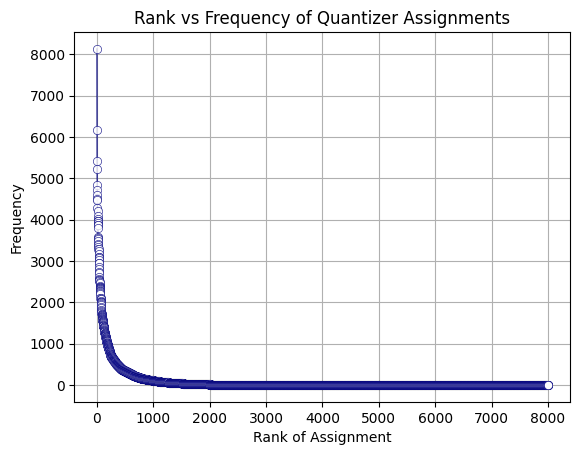

(294841,)

In [95]:
## plot skew
vvids = get_centroid_ids_per_query(
    # index_ivf, 
    untrained_index, 
    selected_vectors, 
    # selected_vectors[0:1,:], 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
)

pids_v, p_v = get_points_in_invlists(untrained_index, vvids)
pids_v.shape


## plot skew
vvids = get_centroid_ids_per_query(
    # index_ivf, 
    trained_index, 
    selected_vectors, 
    # selected_vectors[0:1,:], 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
)

pids_v, p_v = get_points_in_invlists(trained_index, vvids)
pids_v.shape

vvids = get_centroid_ids_per_query(
    # index_ivf, 
    cracked_index, 
    selected_vectors, 
    # selected_vectors[0:1,:], 
    nprobe=nprobe_cracked, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

pids_v, p_v = get_points_in_invlists(cracked_index, vvids)
pids_v.shape

vvids = get_centroid_ids_per_query(
    # index_ivf, 
    cracked_index_2, 
    selected_vectors, 
    # selected_vectors[0:1,:], 
    nprobe=nprobe_cracked, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

pids_v, p_v = get_points_in_invlists(cracked_index_2, vvids)
pids_v.shape

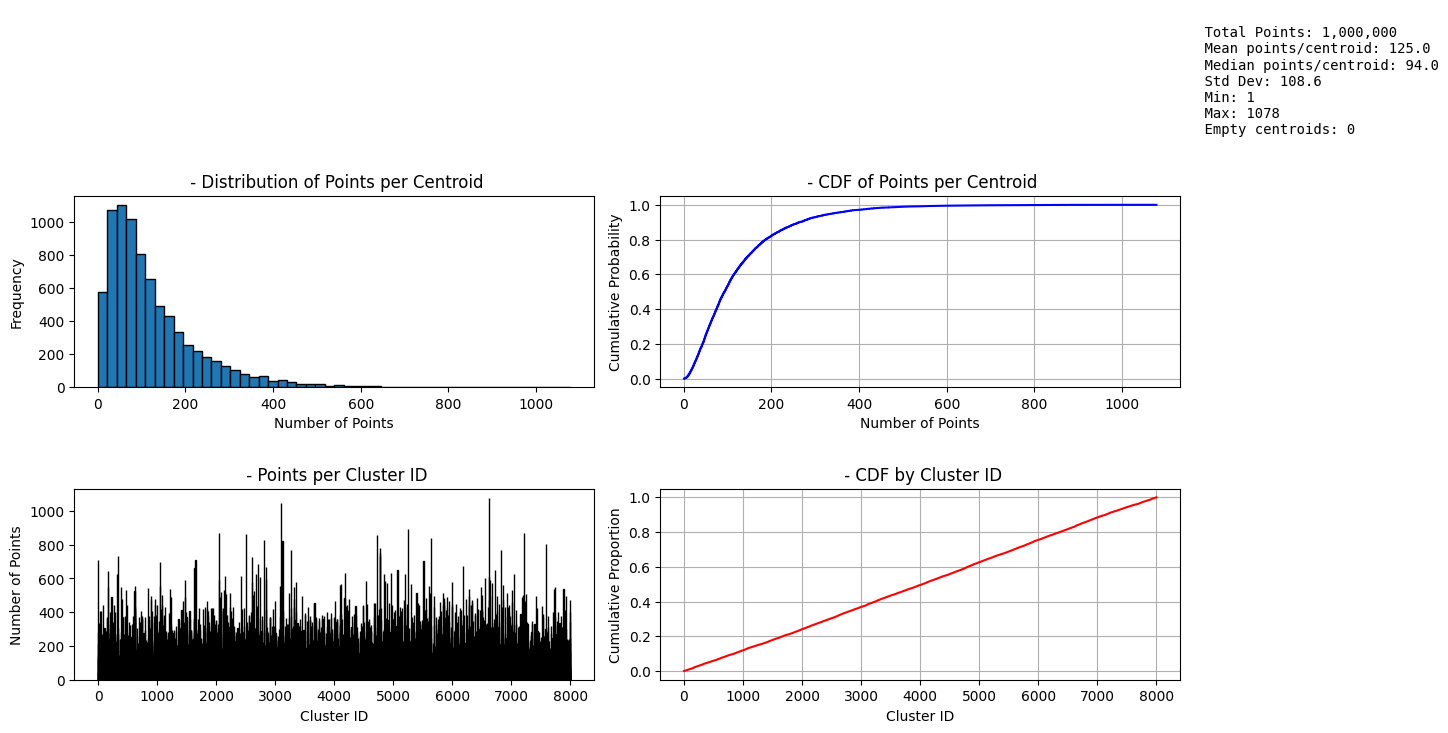

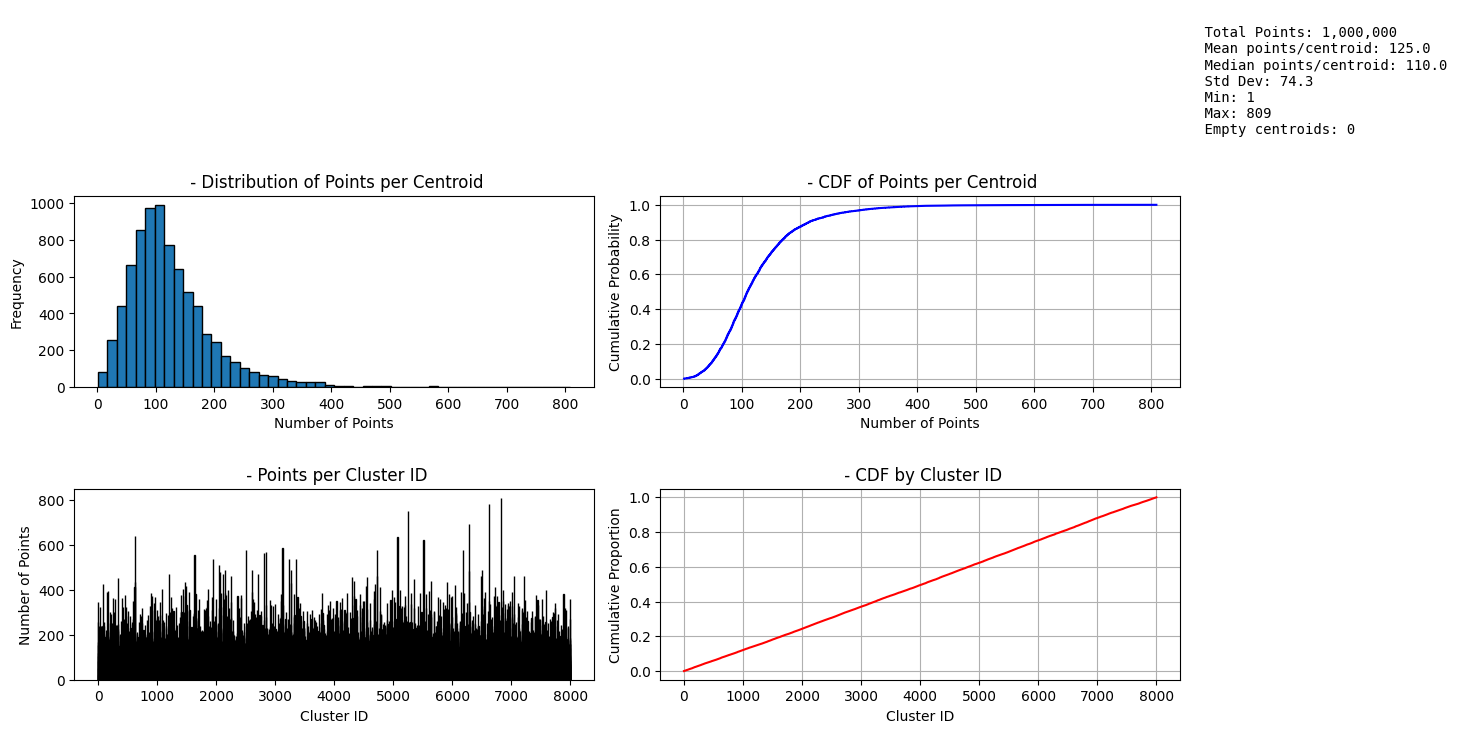

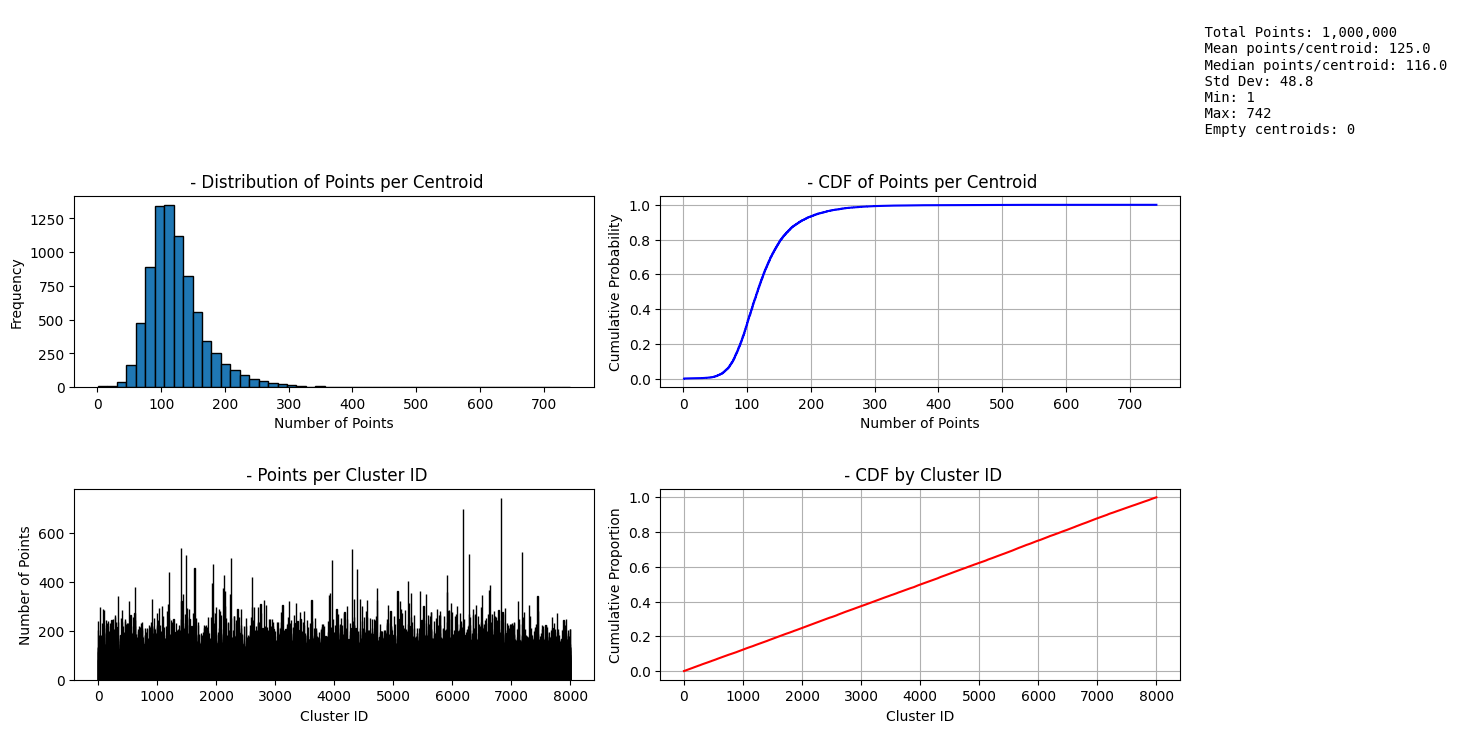

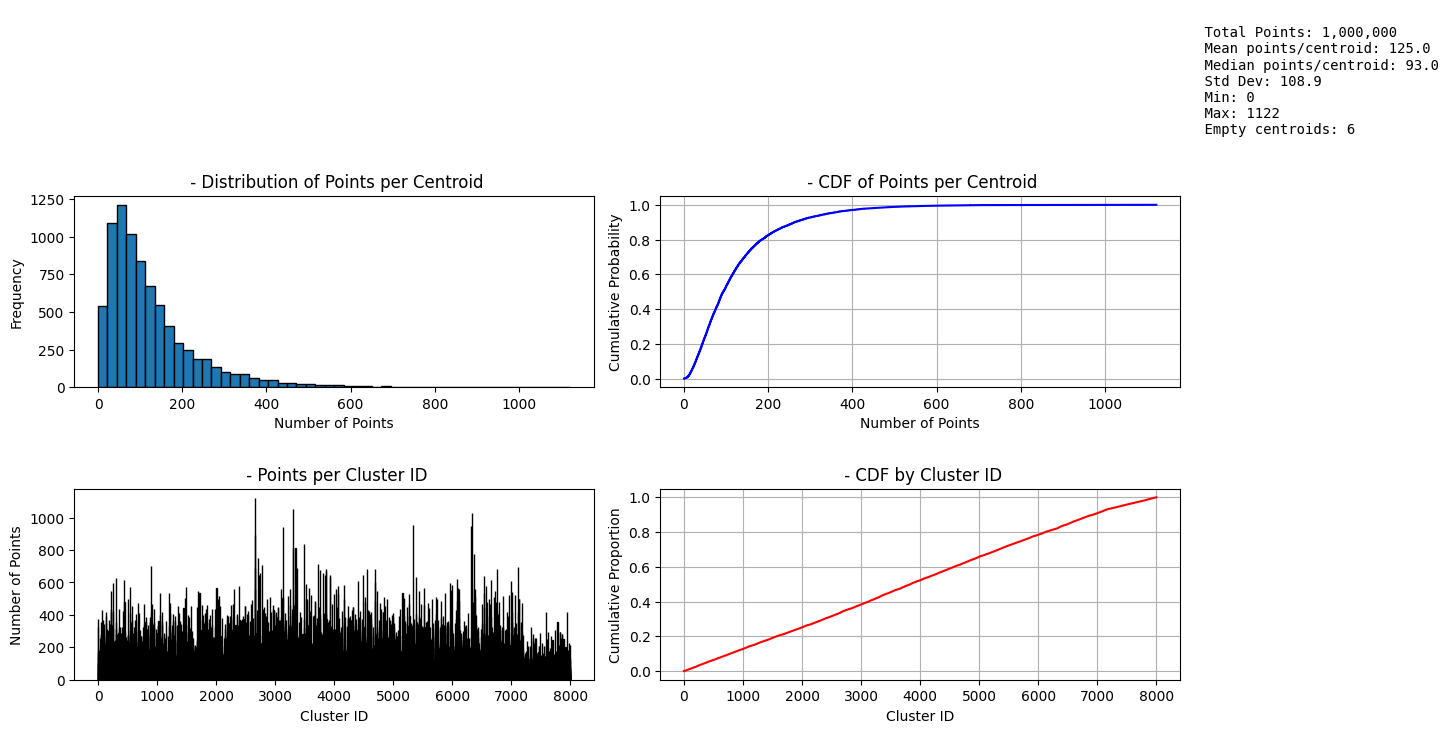

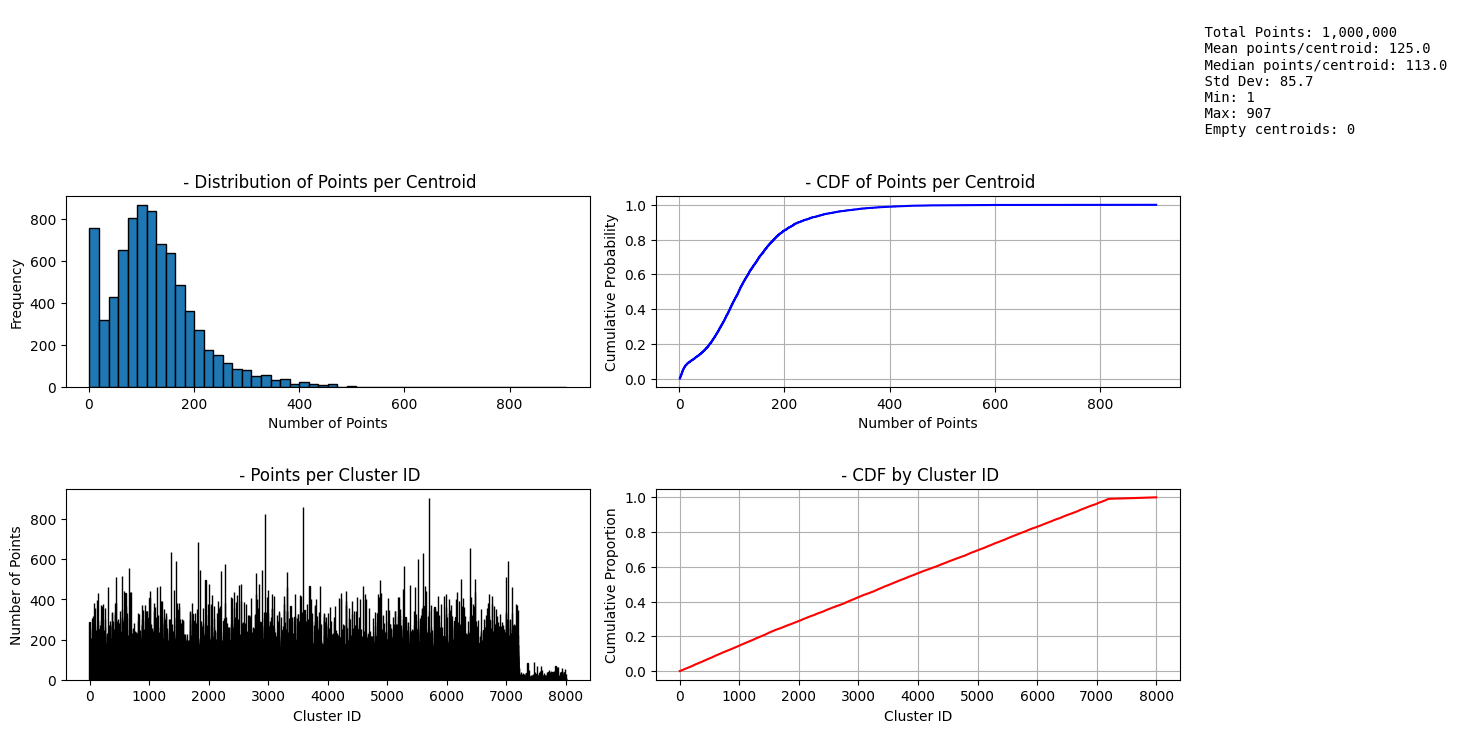

In [96]:
_ = analyze_cluster_distribution(untrained_index)
_ = analyze_cluster_distribution(train1_index)
_ = analyze_cluster_distribution(trained_index)
_ = analyze_cluster_distribution(cracked_index)
_ = analyze_cluster_distribution(cracked_index_2)

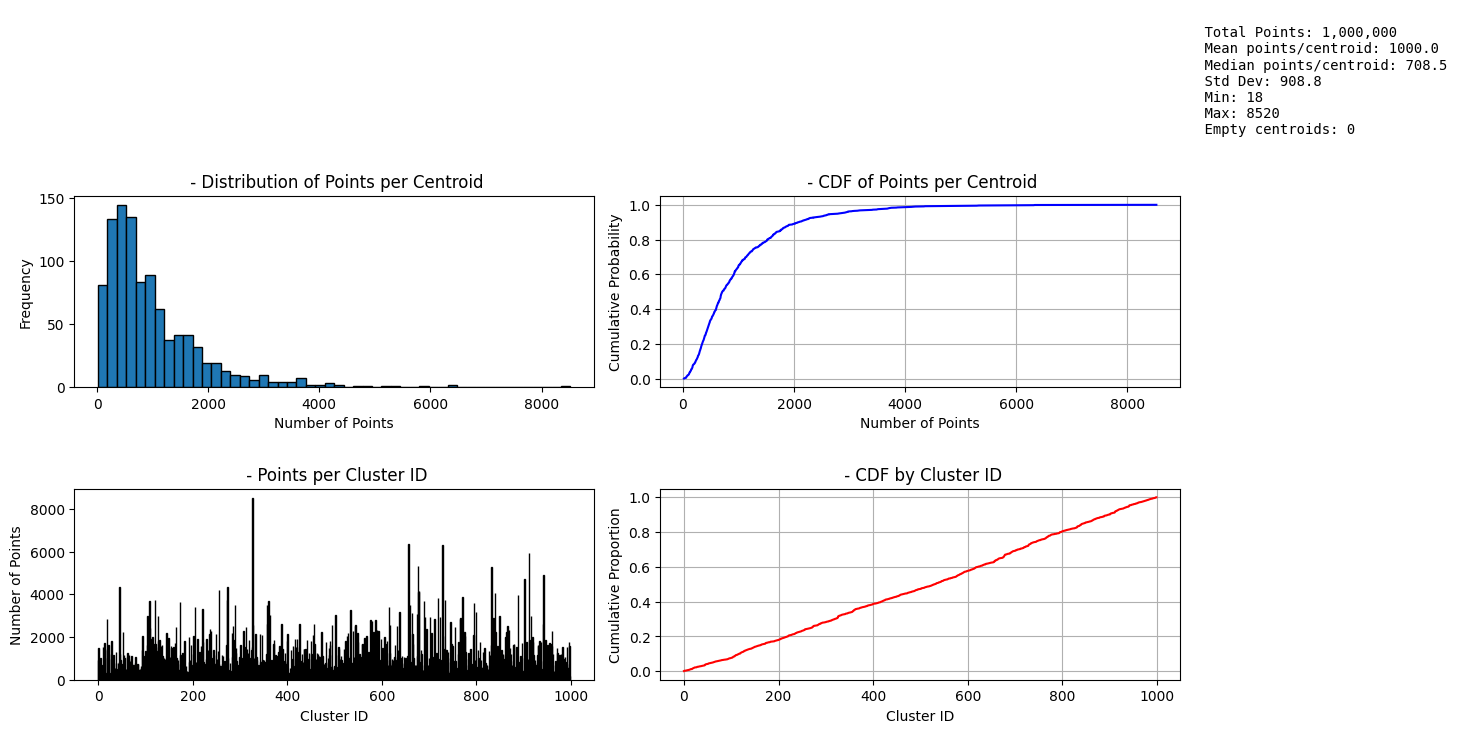

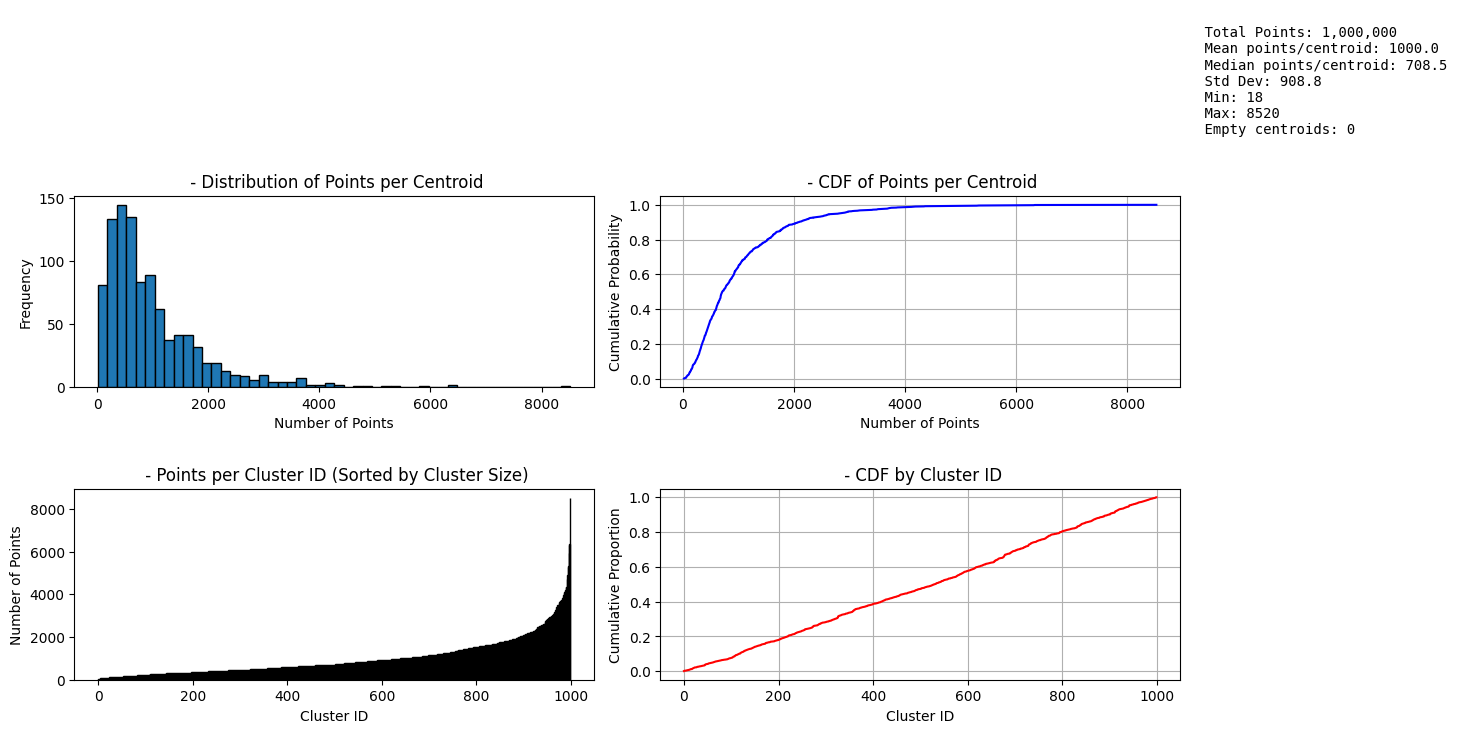

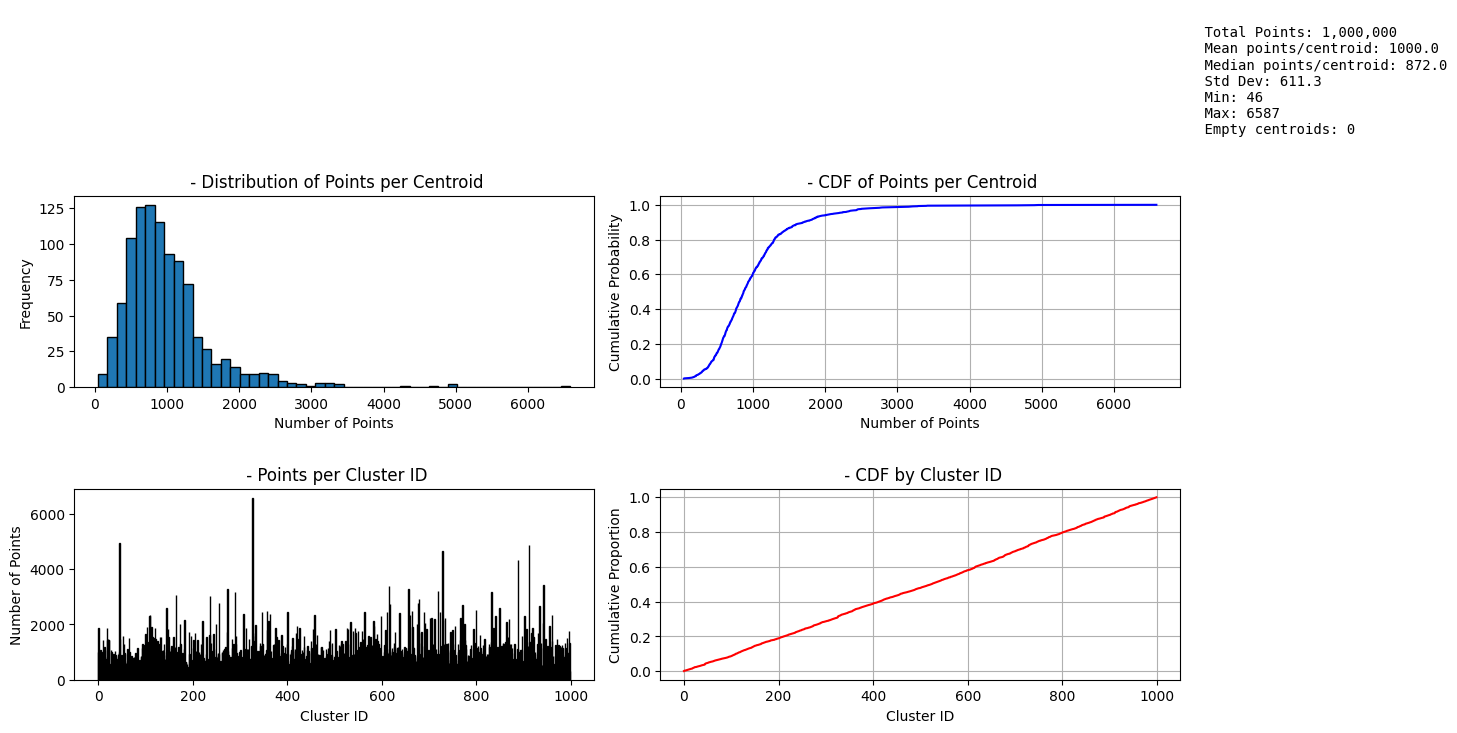

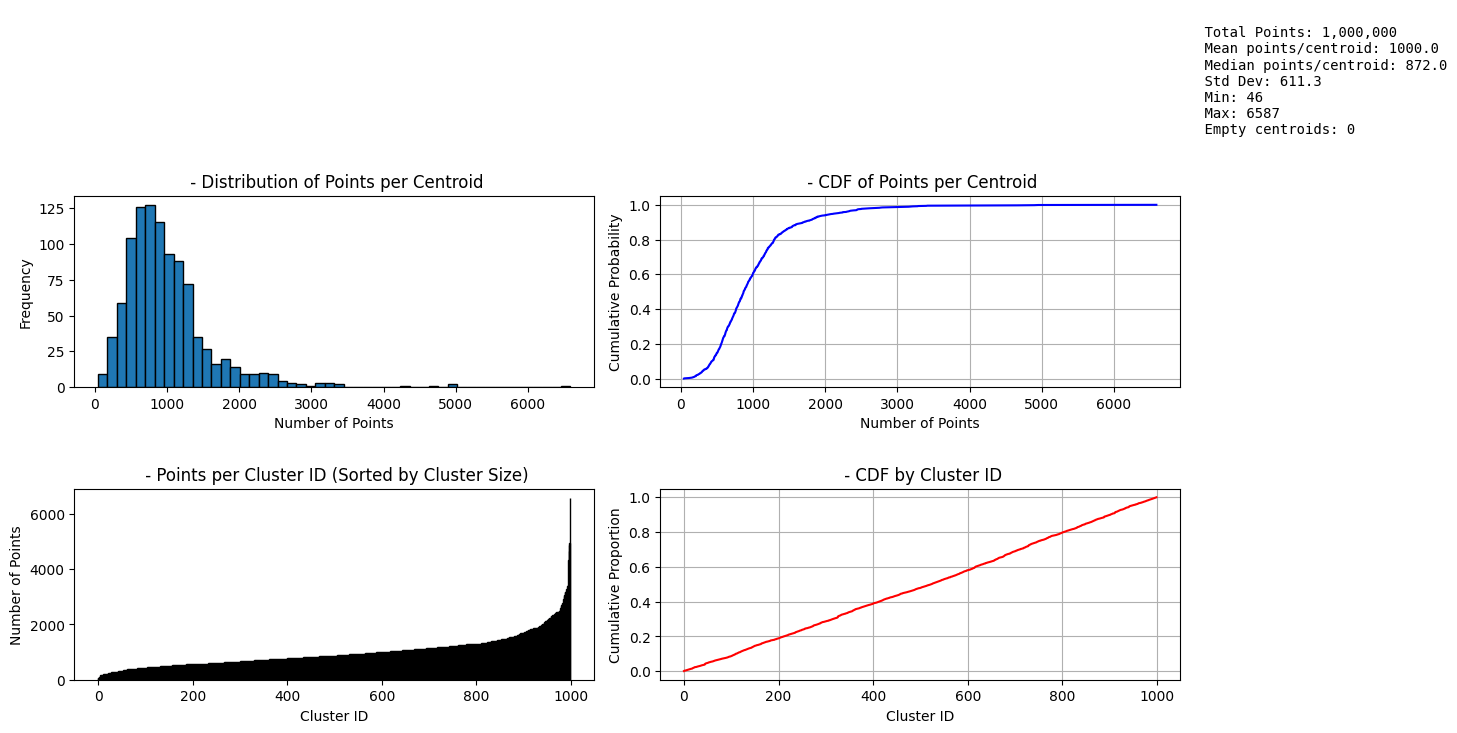

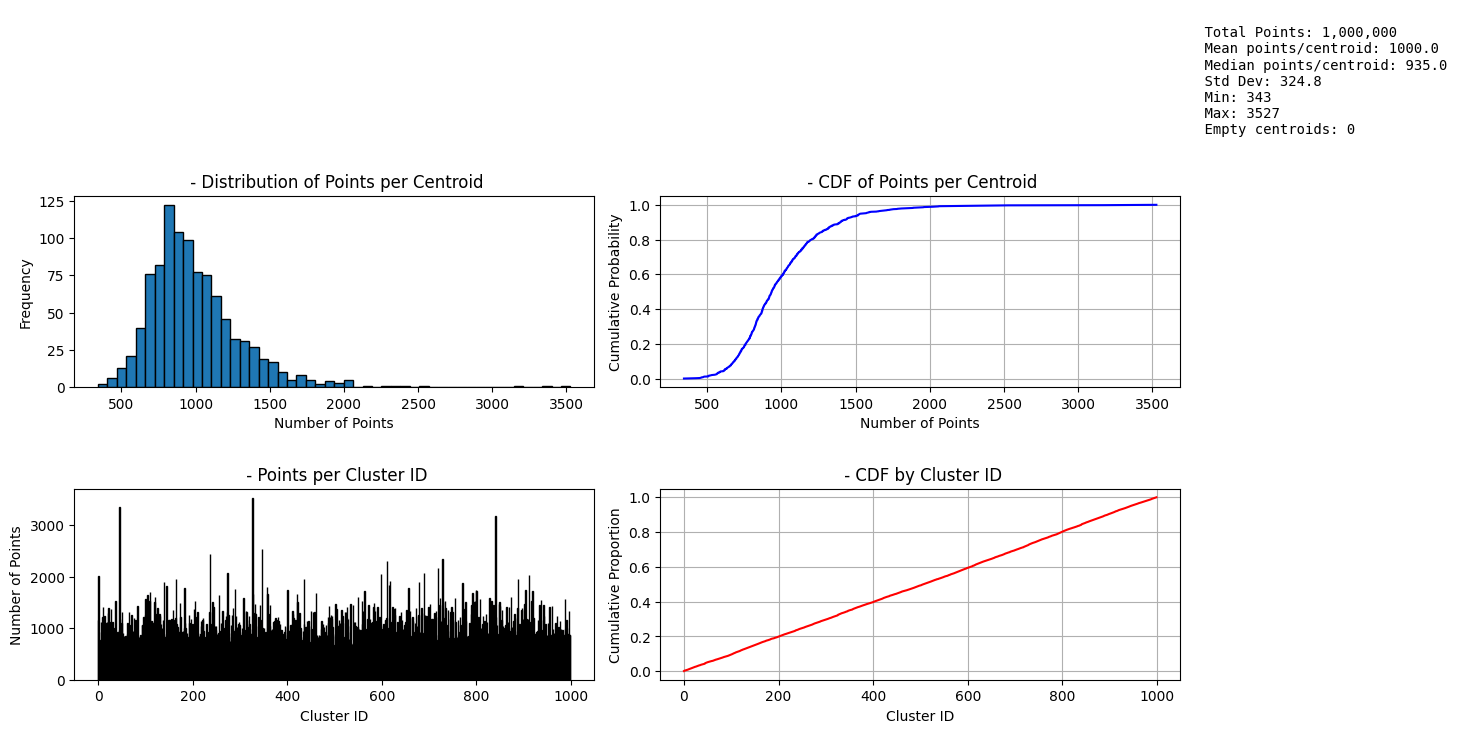

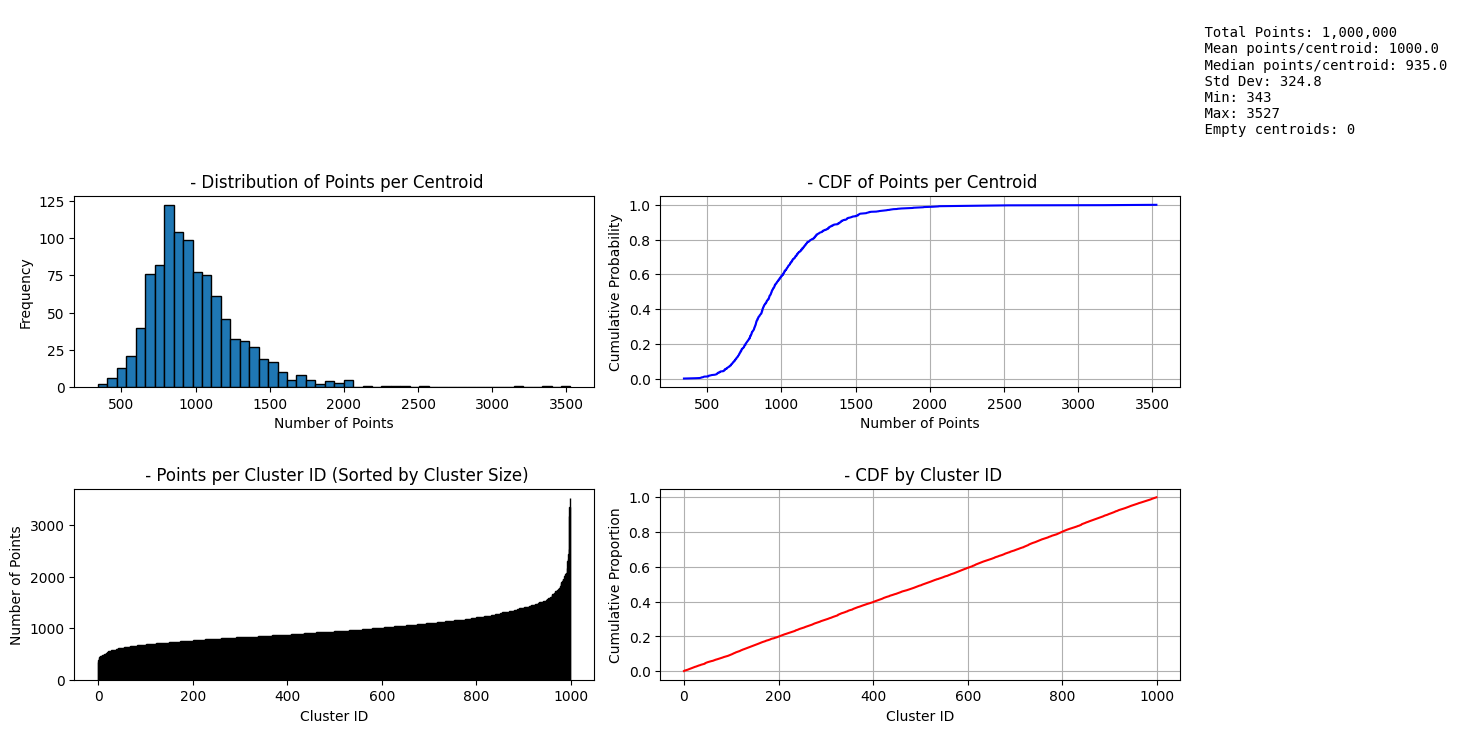

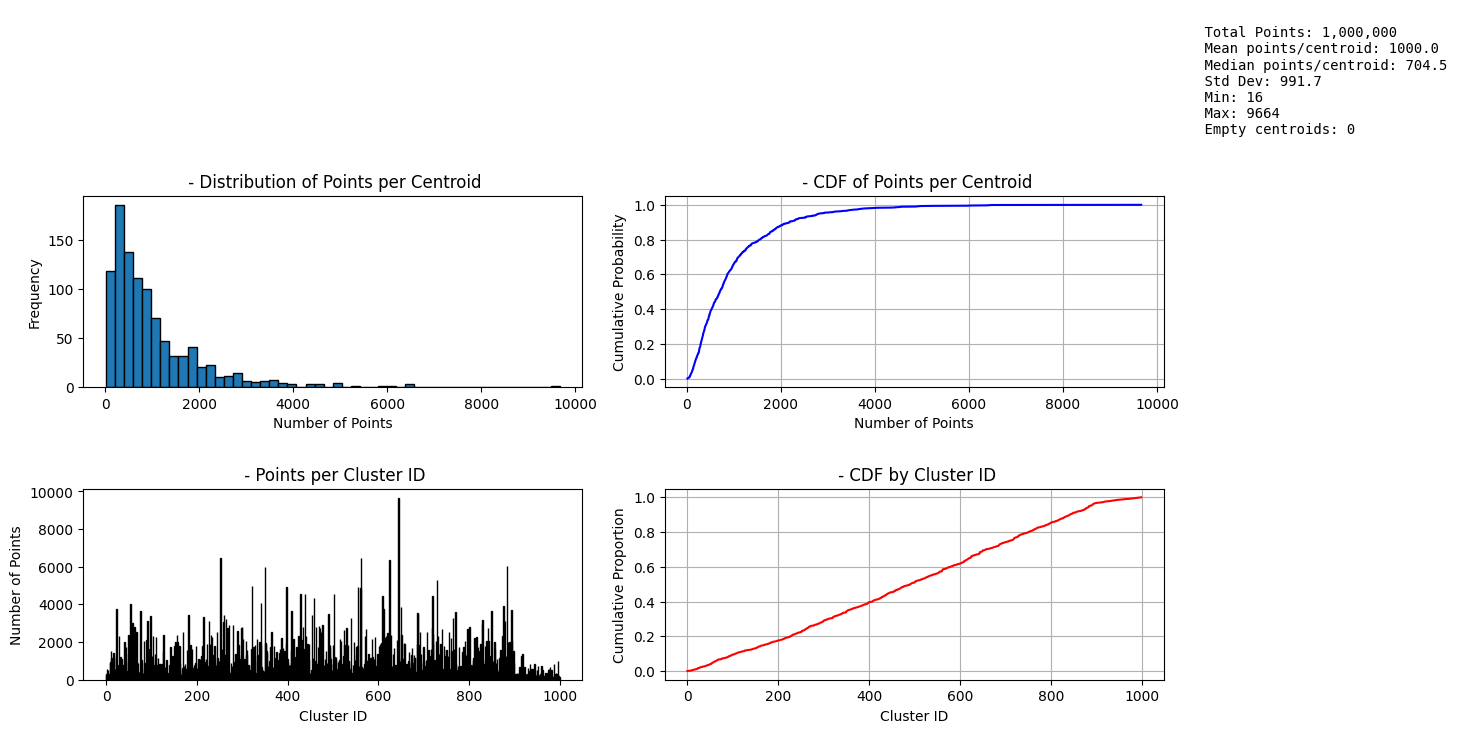

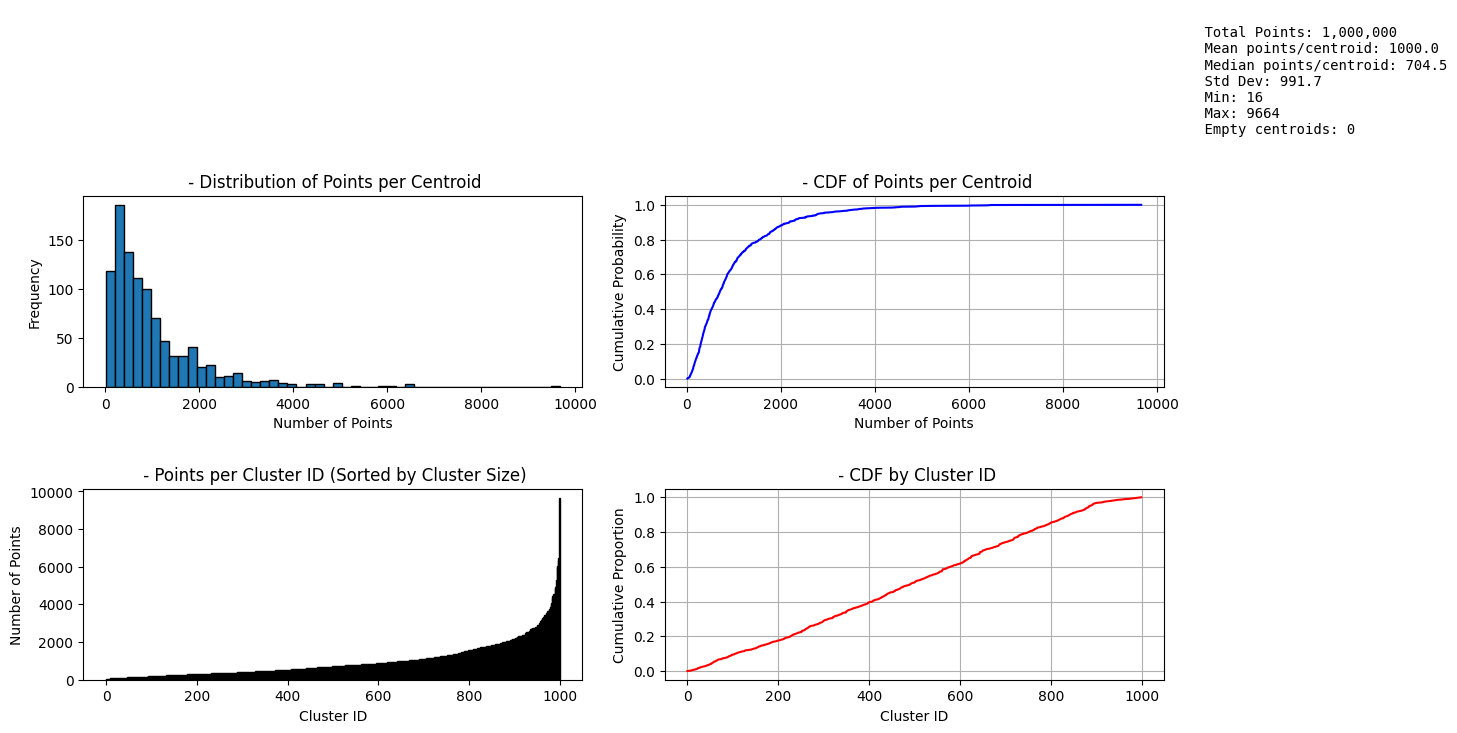

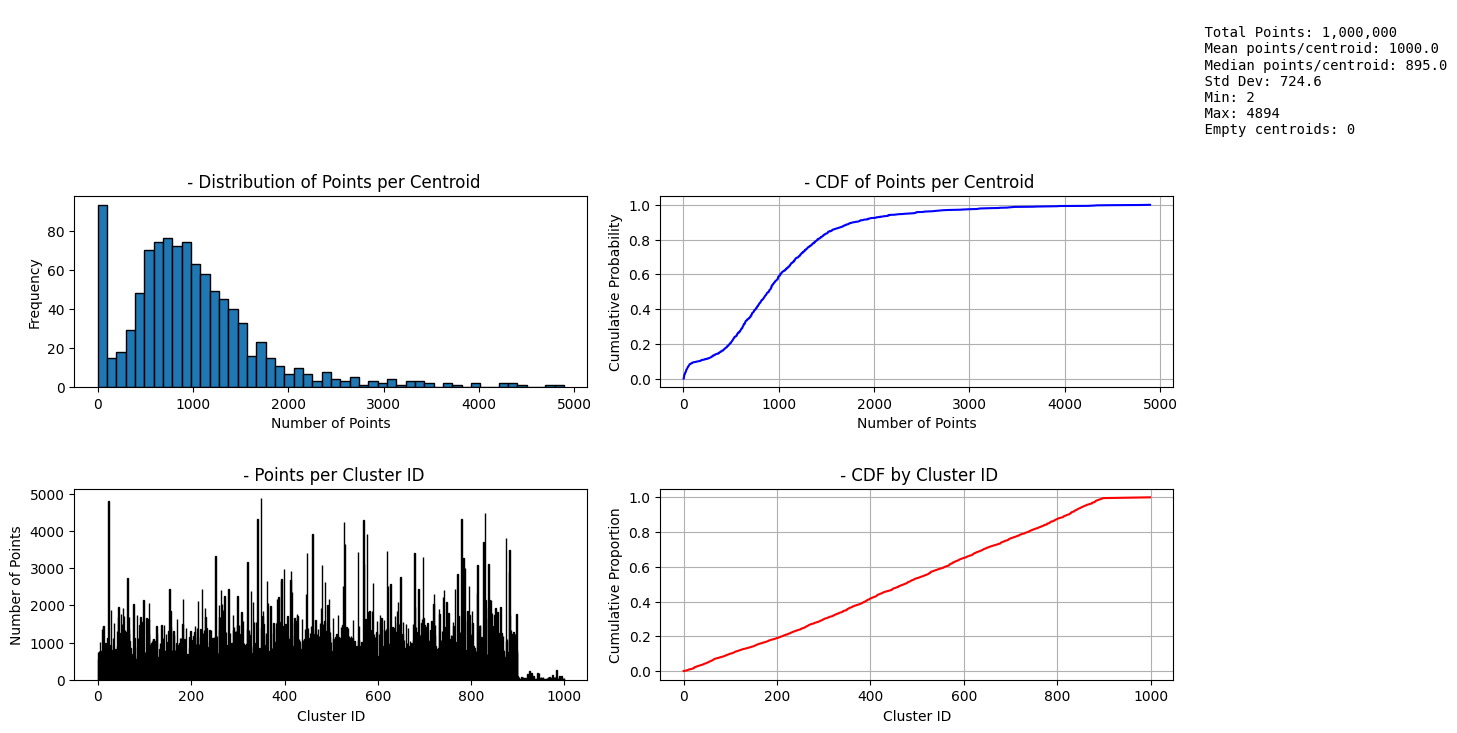

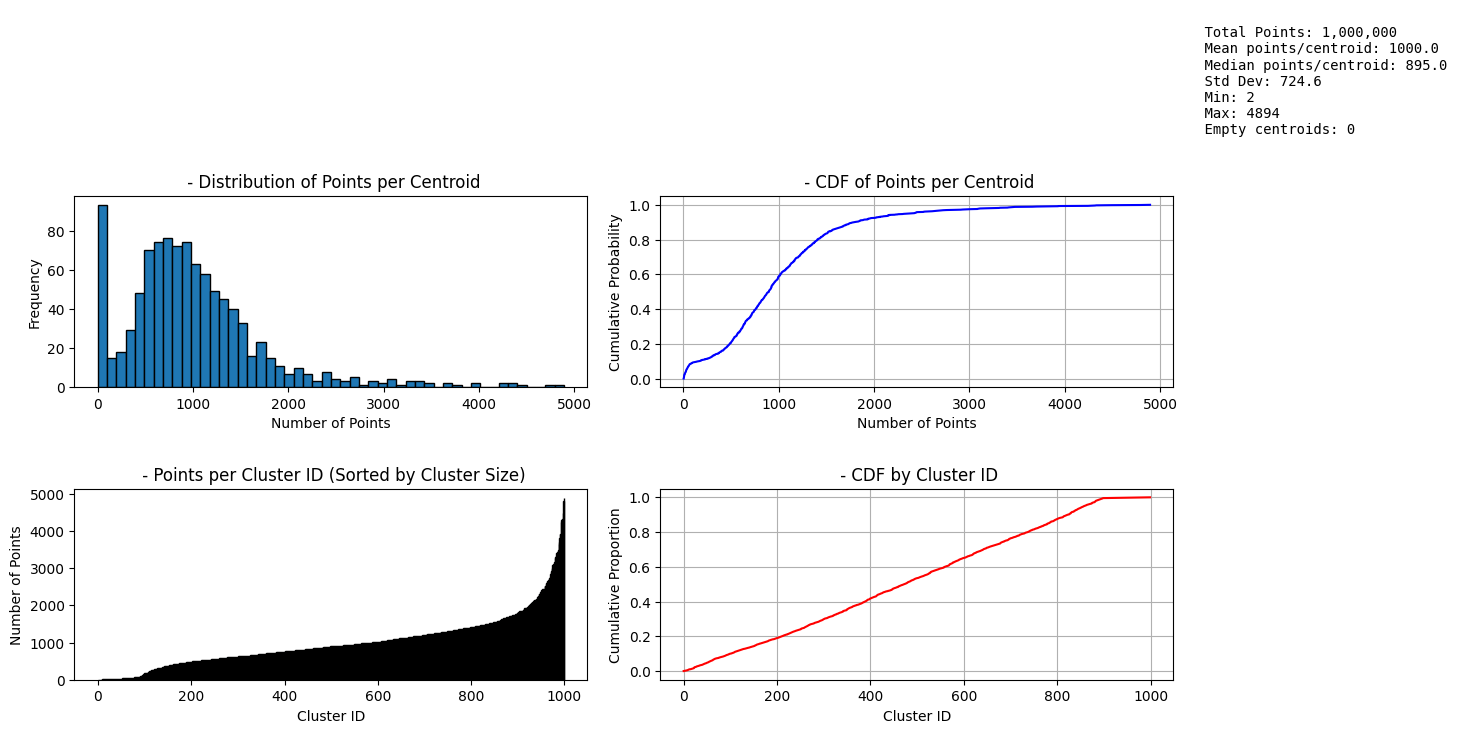

In [98]:
_ = analyze_cluster_distribution(untrained_index)
_ = analyze_cluster_distribution(untrained_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(train1_index)
_ = analyze_cluster_distribution(train1_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(trained_index)
_ = analyze_cluster_distribution(trained_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(cracked_index)
_ = analyze_cluster_distribution(cracked_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(cracked_index_2)
_ = analyze_cluster_distribution(cracked_index_2,plt_sorted=True)

In [99]:
from vasili_helpers import *

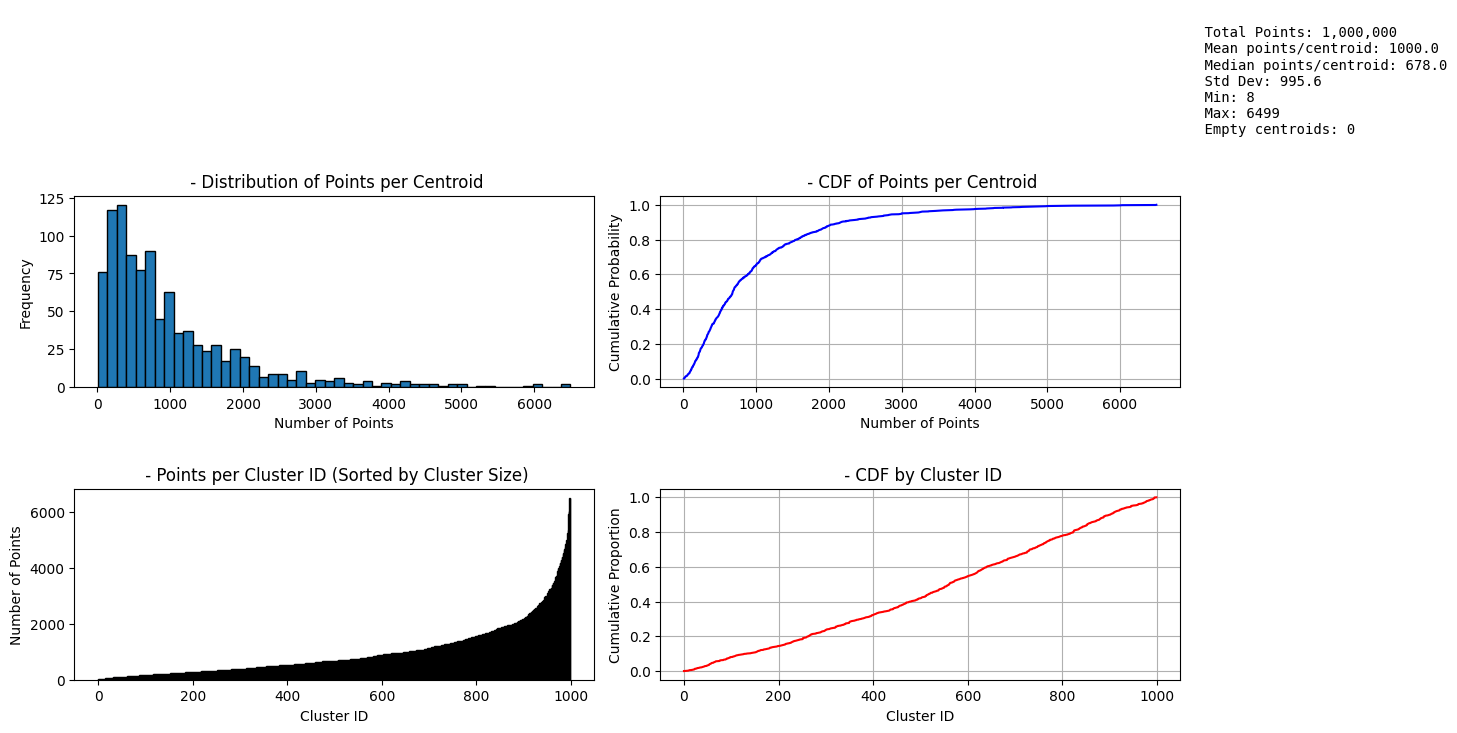

{0: 28,
 1: 56,
 2: 512,
 3: 111,
 4: 153,
 5: 140,
 6: 239,
 7: 29,
 8: 276,
 9: 537,
 10: 806,
 11: 1343,
 12: 971,
 13: 111,
 14: 79,
 15: 230,
 16: 672,
 17: 155,
 18: 1042,
 19: 231,
 20: 516,
 21: 481,
 22: 1026,
 23: 3282,
 24: 544,
 25: 143,
 26: 284,
 27: 726,
 28: 2148,
 29: 630,
 30: 191,
 31: 28,
 32: 1036,
 33: 644,
 34: 971,
 35: 201,
 36: 363,
 37: 339,
 38: 748,
 39: 561,
 40: 466,
 41: 1674,
 42: 387,
 43: 1305,
 44: 1729,
 45: 455,
 46: 87,
 47: 208,
 48: 866,
 49: 2005,
 50: 1047,
 51: 1621,
 52: 94,
 53: 804,
 54: 4167,
 55: 1188,
 56: 886,
 57: 938,
 58: 2705,
 59: 1443,
 60: 323,
 61: 481,
 62: 266,
 63: 2397,
 64: 1106,
 65: 511,
 66: 1528,
 67: 2063,
 68: 940,
 69: 183,
 70: 221,
 71: 169,
 72: 57,
 73: 325,
 74: 113,
 75: 358,
 76: 3465,
 77: 104,
 78: 936,
 79: 235,
 80: 24,
 81: 342,
 82: 139,
 83: 155,
 84: 1953,
 85: 756,
 86: 32,
 87: 384,
 88: 320,
 89: 2016,
 90: 861,
 91: 3256,
 92: 110,
 93: 203,
 94: 1264,
 95: 586,
 96: 1667,
 97: 342,
 98: 3231,
 99

In [ ]:
analyze_cluster_distribution(cracked_index_2,plt_sorted=True)